In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skrub import GapEncoder

In [2]:
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")

train.shape, test.shape

((17499636, 19), (4393179, 19))

In [3]:
train.head()

,status,gender,firstName,level,lastName,userId,ts,auth,page,sessionId,location,itemInSession,userAgent,method,length,song,artist,time,registration
0,200,M,Shlok,paid,Johnson,1749042,1538352001000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",278,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,524.32934,Ich mache einen Spiegel - Dream Part 4,Popol Vuh,2018-10-01 00:00:01,2018-08-08 13:22:21
992,200,M,Shlok,paid,Johnson,1749042,1538352525000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",279,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,178.02404,Monster (Album Version),Skillet,2018-10-01 00:08:45,2018-08-08 13:22:21
1360,200,M,Shlok,paid,Johnson,1749042,1538352703000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",280,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,232.61995,Seven Nation Army,The White Stripes,2018-10-01 00:11:43,2018-08-08 13:22:21
1825,200,M,Shlok,paid,Johnson,1749042,1538352935000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",281,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,265.50812,Under The Bridge (Album Version),Red Hot Chili Peppers,2018-10-01 00:15:35,2018-08-08 13:22:21
2366,200,M,Shlok,paid,Johnson,1749042,1538353200000,Logged In,NextSong,22683,"Dallas-Fort Worth-Arlington, TX",282,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",PUT,471.69261,Circlesong 6,Bobby McFerrin,2018-10-01 00:20:00,2018-08-08 13:22:21


In [4]:
train.columns

Index(['status', 'gender', 'firstName', 'level', 'lastName', 'userId', 'ts',
       'auth', 'page', 'sessionId', 'location', 'itemInSession', 'userAgent',
       'method', 'length', 'song', 'artist', 'time', 'registration'],
      dtype='object')

In [5]:
train.dtypes

status                    int64
gender                   object
firstName                object
level                    object
lastName                 object
userId                   object
ts                        int64
auth                     object
page                     object
sessionId                 int64
location                 object
itemInSession             int64
userAgent                object
method                   object
length                  float64
song                     object
artist                   object
time             datetime64[us]
registration     datetime64[us]
dtype: object

In [6]:
train['time'].min(), train['time'].max()

(Timestamp('2018-10-01 00:00:01'), Timestamp('2018-11-20 00:00:00'))

**Conceptual Outline**:

Our key columns are userId, time and page. We want features that describe how the user behaved before the prediction point, not after, to prevent leakage from the future. 

Thus, we define a prediction time for each user. We want to predict churn in the next 10 days, thus we need a moment in time $T_\text{pred}$ at which we pretend to make the prediction. 

Then, there are two options. 1) The user churns (has a "cancellation confirmation" event), then we set $T_\text{pred}$ 10 days before $T_\text{churn}$. 2) The user does not churn in the training set, then we set the prediction time 10 days before the last observed event. $T_\text{pred} = T_\text{pred} - 10 \text{days}$.

Everythin we compute as features must only ever use events with time before $T_\text{pred}$, otherwise we have data leakage.

**Feature 1**:

I propose "recency of activity" , i.e. days since last event, as a feature predicting churn. Users who have not done anything for a long time are more likely to churn. For each user, we look at all events with timestamp before $T_\text{pred}$ and find the last event before $T_\text{pred}$.

A possible interpretation would be: Small value: The user was active right before the prediction point and has lower churn risk. Large value: The user was inactive for many days, higher churn risk.

**Feature 2:**

I propose short-term activity level as a predictor of churn. 

We define a seven day lookback window $[T_\text{pred} - 7 \text{days}, T_\text{pred}]$. Then, we count all events in this window and construct the feature "events_last_7d". 

Rationale: Many events in the last seven days before $T_\text{pred}$ indicates that the user likes the service, uses it regularly and thus is unlikely to churn. If the user barely uses the servide, he is more likely to cancel the subscription.

**Feature 2.1:**

A very similar feature with a seven days lookback window can be included with the sole difference that we only consider songs played as events in the window. In the end, users use the service to listen to songs and thus the number of songs played in the last seven days before prediction_ts might be a better indicator of churn inclination than the total amount of events. 

In [7]:
df = train.copy()

In [8]:
# global timestamps
min_ts = df['time'].min()
max_ts = df['time'].max()
# define time deltas 
delta_7d = pd.Timedelta(days=7)
delta_10d = pd.Timedelta(days=10)

# first estimation window: observe 7 days after min_ts, predict churn in next 10 days
observation_start = min_ts
observation_end = observation_start + delta_7d
prediction_end = observation_end + delta_10d

# create mask for observation and prediction windows
obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
pred_mask = (df['time'] >= observation_end) & (df['time'] < prediction_end)

# check whether churn occurred in prediction window
churn_in_pred_window = df[pred_mask & (df['page'] == 'Cancellation Confirmation')]

# create subset of users present in observation window
users_in_obs_window = df[obs_mask]['userId'].unique()
df = df[df['userId'].isin(users_in_obs_window)]

# df contains users active in observation window
# restrict dataset to prediction window
df_pred_window = df[pred_mask]

# add churn flag per user
churned_users = churn_in_pred_window['userId'].unique()

# user level table: userId and binary churn flag
user_data = pd.DataFrame({'userId': users_in_obs_window})
user_data['churned'] = np.where(
    user_data['userId'].isin(churned_users), 1, 0
)

/var/folders/ch/v853cmgj3bv0njvrdjd2kdcc0000gn/T/ipykernel_55163/3662243075.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_pred_window = df[pred_mask]


In [9]:
user_data['churned'].value_counts()

churned
0    12654
1      854
Name: count, dtype: int64

In [10]:
user_data

,userId,churned
0,1749042,0
1,1563081,0
2,1697168,0
3,1222580,0
4,1714398,0
...,...,...
13503,1740270,0
13504,1486999,0
13505,1216336,0
13506,1775697,0


In [11]:
def create_features(df, observation_start, observation_end):

    # filter observation window
    obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
    df_obs = df[obs_mask]
    
    user_ids = df_obs['userId'].unique()
    features = pd.DataFrame({'userId': user_ids})
    
    # --- total_events: total number of events per user ---
    total_events = (
        df_obs.groupby('userId')
        .size()
        .reset_index(name='total_events')
    )
    features = features.merge(total_events, on='userId', how='left')
    
    # --- page-based features: page visit counts ---
    page_features = {
        'songs_played': 'NextSong',
        'roll_advert': 'Roll Advert',
        'settings': 'Settings',
        'add_playlist': 'Add to Playlist',
        'thumbs_up': 'Thumbs Up',
        'home': 'Home',
        'help': 'Help',
        'logout': 'Logout',
        'about': 'About',
        'upgrade': 'Upgrade',
        'submit_upgrade': 'Submit Upgrade',
        'thumbs_down': 'Thumbs Down',
        'downgrade': 'Downgrade',
        'add_friend': 'Add Friend',
        'error': 'Error',
        'save_settings': 'Save Settings',
        'submit_downgrade': 'Submit Downgrade',
        'login': 'Login',
        'register': 'Register',
        'submit_registration': 'Submit Registration',
    }
    
    for col_name, page_name in page_features.items():
        page_counts = (
            df_obs[df_obs['page'] == page_name]
            .groupby('userId')
            .size()
            .reset_index(name=col_name)
        )
        features = features.merge(page_counts, on='userId', how='left')
    
    # ------------------------------------------------------------------
    # NEW FEATURE SECTION (sessions, ratios, tenure 등)  ← 그대로 둬도 됨
    # ------------------------------------------------------------------

    # (A) Count events per session
    session_events = (
        df_obs.groupby(['userId', 'sessionId'])
        .size()
        .reset_index(name='events_in_session')
    )
    
    num_sessions = (
        session_events.groupby('userId')['sessionId']
        .nunique()
        .reset_index(name='num_sessions')
    )
    features = features.merge(num_sessions, on='userId', how='left')
    
    events_per_session = (
        session_events.groupby('userId')['events_in_session']
        .mean()
        .reset_index(name='events_per_session')
    )
    features = features.merge(events_per_session, on='userId', how='left')
    
    # (B) songs per session + song stats
    nextsong_obs = df_obs[df_obs['page'] == 'NextSong']
    
    if not nextsong_obs.empty:
        session_songs = (
            nextsong_obs.groupby(['userId', 'sessionId'])
            .size()
            .reset_index(name='songs_in_session')
        )
        
        songs_per_session = (
            session_songs.groupby('userId')['songs_in_session']
            .mean()
            .reset_index(name='songs_per_session')
        )
        features = features.merge(songs_per_session, on='userId', how='left')
        
        song_stats = (
            nextsong_obs.groupby('userId')
            .agg(
                total_song_length=('length', 'sum'),
                avg_song_length=('length', 'mean'),
                median_song_length=('length', 'median'),
            )
            .reset_index()
        )
        features = features.merge(song_stats, on='userId', how='left')
        
    # (C) Ratios
    features['song_share'] = (
        features['songs_played'] / features['total_events'].replace(0, np.nan)
    )
    features['ad_per_song'] = (
        features['roll_advert'] / features['songs_played'].replace(0, np.nan)
    )
    features['thumbs_up_rate'] = (
        features['thumbs_up'] / features['songs_played'].replace(0, np.nan)
    )
    features['thumbs_down_rate'] = (
        features['thumbs_down'] / features['songs_played'].replace(0, np.nan)
    )
    
    # (D) Page diversity + active days
    unique_pages = (
        df_obs.groupby('userId')['page']
        .nunique()
        .reset_index(name='unique_pages')
    )
    features = features.merge(unique_pages, on='userId', how='left')
    
    active_days = (
        df_obs.assign(date=df_obs['time'].dt.date)
        .groupby('userId')['date']
        .nunique()
        .reset_index(name='active_days')
    )
    features = features.merge(active_days, on='userId', how='left')
    
    # (E) tenure_days
    if 'registration' in df.columns:
        reg = df[['userId', 'registration']].drop_duplicates('userId').copy()
        
        if not np.issubdtype(reg['registration'].dtype, np.datetime64):
            reg['registration_dt'] = pd.to_datetime(reg['registration'], unit='ms')
        else:
            reg['registration_dt'] = reg['registration']
        
        reg['tenure_days'] = (observation_end - reg['registration_dt']).dt.days
        reg = reg[['userId', 'tenure_days']]
        features = features.merge(reg, on='userId', how='left')
    
    # ------------------------------------------------------------------
    # (F) userAgent cleaning and mode extraction
    # ------------------------------------------------------------------
    if 'userAgent' in df.columns:
        ua_df = df_obs[['userId', 'userAgent']].copy()
        ua_df['userAgent'] = ua_df['userAgent'].fillna("Unknown")
        ua_df['ua_clean'] = (
            ua_df['userAgent']
            .str.lower()
            .str.replace('[^a-z0-9 ]', ' ', regex=True)
            .str.replace('\s+', ' ', regex=True)
            .str.strip()
        )
        
        ua_counts = (
            ua_df.groupby(['userId', 'ua_clean'])
            .size()
            .reset_index(name='cnt')
        )
        ua_mode = (
            ua_counts
            .sort_values(['userId', 'cnt'], ascending=[True, False])
            .drop_duplicates('userId')
            [['userId', 'ua_clean']]
        )
        ua_mode = ua_mode.rename(columns={'ua_clean': 'ua_clean_mode'})
        
        features = features.merge(ua_mode, on='userId', how='left')
    
    # fill missing feature values with 0 (ua_clean_mode은 문자열이라 그대로 NaN 가능)
    num_cols = features.select_dtypes(include=[np.number]).columns
    features[num_cols] = features[num_cols].fillna(0)
    
    return features

In [12]:
# create features for first observation window, then merge to user_data
features_1 = create_features(df, observation_start, observation_end)
user_data = user_data.merge(features_1, on='userId', how='left')

In [13]:
# print all the feature columns
user_data.columns.tolist()

['userId',
 'churned',
 'total_events',
 'songs_played',
 'roll_advert',
 'settings',
 'add_playlist',
 'thumbs_up',
 'home',
 'help',
 'logout',
 'about',
 'upgrade',
 'submit_upgrade',
 'thumbs_down',
 'downgrade',
 'add_friend',
 'error',
 'save_settings',
 'submit_downgrade',
 'login',
 'register',
 'submit_registration',
 'num_sessions',
 'events_per_session',
 'songs_per_session',
 'total_song_length',
 'avg_song_length',
 'median_song_length',
 'song_share',
 'ad_per_song',
 'thumbs_up_rate',
 'thumbs_down_rate',
 'unique_pages',
 'active_days',
 'tenure_days',
 'ua_clean_mode']

In [14]:
def feature_engineering_single_window(df, observation_end,
                                      obs_days=14, pred_days=10):
    """
    Create training rows for a single observation window ending at `observation_end`:
      - observe [observation_end - obs_days, observation_end)
      - predict churn in the next pred_days days
    Uses your create_features with 14d window + last 7d + ratios.
    """
    delta_obs = pd.Timedelta(days=obs_days)
    delta_pred = pd.Timedelta(days=pred_days)
    delta_7d = pd.Timedelta(days=7)

    observation_start = observation_end - delta_obs
    pred_start = observation_end
    pred_end = observation_end + delta_pred

    df = df.sort_values('time')

    # 1) users in observation window
    obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
    users_in_obs_window = df.loc[obs_mask, 'userId'].unique()
    if len(users_in_obs_window) == 0:
        return None

    df_obs_users = df[df['userId'].isin(users_in_obs_window)]

    # 2) churn in prediction window (only those users)
    pred_mask = (df['time'] >= pred_start) & (df['time'] < pred_end)
    df_pred = df[pred_mask & df['userId'].isin(users_in_obs_window)]
    churn_in_pred_window = df_pred[df_pred['page'] == 'Cancellation Confirmation']
    churned_users = churn_in_pred_window['userId'].unique()

    # 3) user-level label
    user_data = pd.DataFrame({'userId': users_in_obs_window})
    user_data['churned'] = np.where(
        user_data['userId'].isin(churned_users), 1, 0
    )

    # 4) 14-day features (same as your feature_engineering)
    features_14 = create_features(df_obs_users, observation_start, observation_end)
    user_data = user_data.merge(features_14, on='userId', how='left')

    # 5) last-7-days features inside the 14-day observation window
    last_7_start = observation_end - delta_7d
    features_7 = create_features(df_obs_users, last_7_start, observation_end)
    user_data = user_data.merge(
        features_7,
        on='userId',
        how='left',
        suffixes=('', '_7d')
    )

    # 6) ratios 14d vs 7d
    ratio_specs = [
        ('total_events',      'total_events_7d',      'event_ratio_14d_7d'),
        ('songs_played',      'songs_played_7d',      'song_ratio_14d_7d'),
        ('total_song_length', 'total_song_length_7d', 'song_length_ratio_14d_7d'),
    ]
    for col_14, col_7, col_ratio in ratio_specs:
        if col_14 in user_data.columns and col_7 in user_data.columns:
            user_data[col_ratio] = user_data[col_14] / (user_data[col_7] + 1)

    # 7) fill numeric NaNs
    num_cols = user_data.select_dtypes(include=[np.number]).columns
    user_data[num_cols] = user_data[num_cols].fillna(0)

    # keep which window this row came from (for debugging)
    user_data['obs_end'] = observation_end

    return user_data


In [15]:
def feature_engineering_multi_windows(df, n_windows=3):
    """
    Build training data from multiple observation windows across time.
    Each window uses:
      - 14 days observation
      - 10 days prediction
    and we stack all rows together (multiple rows per user possible).
    """
    df = df.sort_values('time').copy()

    min_ts = df['time'].min()
    max_ts = df['time'].max()

    delta_14d = pd.Timedelta(days=14)
    delta_10d = pd.Timedelta(days=10)

    # observation_end must satisfy:
    #   observation_end >= min_ts + 14d  (enough history)
    #   observation_end + 10d <= max_ts (enough future to label)
    earliest_obs_end = min_ts + delta_14d
    latest_obs_end = max_ts - delta_10d

    if latest_obs_end <= earliest_obs_end:
        print("Not enough time range for multiple windows; using a single one.")
        return feature_engineering_single_window(df, earliest_obs_end)

    # choose n_windows observation_end points evenly spaced
    obs_end_values = np.linspace(
        earliest_obs_end.value,
        latest_obs_end.value,
        n_windows
    )
    obs_ends = [pd.to_datetime(v) for v in obs_end_values]

    all_frames = []

    for i, obs_end in enumerate(obs_ends):
        obs_start = obs_end - delta_14d
        print(f"Window {i+1}/{n_windows}: "
              f"observe [{obs_start.date()} – {obs_end.date()}) "
              f"→ predict next 10 days")

        window_df = feature_engineering_single_window(df, obs_end)
        if window_df is None or window_df.empty:
            continue

        window_df['window_id'] = i  # optional marker
        all_frames.append(window_df)

    if not all_frames:
        raise ValueError("No valid windows created in feature_engineering_multi_windows.")

    user_data_all = pd.concat(all_frames, ignore_index=True)

    return user_data_all


In [16]:
user_data_train = feature_engineering_multi_windows(train, n_windows=3)

Window 1/3: observe [2018-10-01 – 2018-10-15) → predict next 10 days
Window 2/3: observe [2018-10-14 – 2018-10-28) → predict next 10 days
Window 3/3: observe [2018-10-27 – 2018-11-10) → predict next 10 days


In [17]:
# === !!!! NEW !!! UA GapEncoder: train fit + transform ===
ua_train = (
    user_data_train['ua_clean_mode']
    .fillna("unknown")
    .astype(str)
)

ge = GapEncoder(n_components=3, random_state=42)
ua_emb_train = ge.fit_transform(ua_train)

ua_emb_train = np.asarray(ua_emb_train)

user_data_train['ua_gap_0'] = ua_emb_train[:, 0]
user_data_train['ua_gap_1'] = ua_emb_train[:, 1]
user_data_train['ua_gap_2'] = ua_emb_train[:, 2]

user_data_train.head()


,userId,churned,total_events,songs_played,roll_advert,settings,add_playlist,thumbs_up,home,help,...,tenure_days_7d,ua_clean_mode_7d,event_ratio_14d_7d,song_ratio_14d_7d,song_length_ratio_14d_7d,obs_end,window_id,ua_gap_0,ua_gap_1,ua_gap_2
0,1749042,1,1129,954.0,0.0,6.0,31.0,46.0,33.0,8.0,...,67.0,mozilla 5 0 windows nt 6 1 wow64 applewebkit 5...,1.897479,1.927273,1.924853,2018-10-15 00:00:01,0,0.000753,1.056161,0.000748
1,1484921,0,205,165.0,3.0,0.0,4.0,13.0,7.0,3.0,...,28.0,mozilla 5 0 x11 linux x86 64 applewebkit 537 3...,2.091837,2.171053,2.124692,2018-10-15 00:00:01,0,0.000985,1.013668,0.001162
2,1694515,0,43,34.0,3.0,0.0,0.0,4.0,1.0,0.0,...,29.0,mozilla 5 0 macintosh intel mac os x 10 9 4 ap...,1.075000,1.062500,1.145046,2018-10-15 00:00:01,0,0.638487,0.533746,0.000505
3,1697168,0,429,344.0,18.0,3.0,8.0,16.0,15.0,3.0,...,36.0,mozilla 5 0 macintosh intel mac os x 10 9 rv 3...,3.325581,3.510204,3.430919,2018-10-15 00:00:01,0,0.356752,0.000458,0.428452
4,1563081,0,28,25.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,NaN,0.000000,0.000000,0.000000,2018-10-15 00:00:01,0,0.638487,0.533746,0.000505


In [18]:
user_data_train.columns.tolist()

['userId',
 'churned',
 'total_events',
 'songs_played',
 'roll_advert',
 'settings',
 'add_playlist',
 'thumbs_up',
 'home',
 'help',
 'logout',
 'about',
 'upgrade',
 'submit_upgrade',
 'thumbs_down',
 'downgrade',
 'add_friend',
 'error',
 'save_settings',
 'submit_downgrade',
 'login',
 'register',
 'submit_registration',
 'num_sessions',
 'events_per_session',
 'songs_per_session',
 'total_song_length',
 'avg_song_length',
 'median_song_length',
 'song_share',
 'ad_per_song',
 'thumbs_up_rate',
 'thumbs_down_rate',
 'unique_pages',
 'active_days',
 'tenure_days',
 'ua_clean_mode',
 'total_events_7d',
 'songs_played_7d',
 'roll_advert_7d',
 'settings_7d',
 'add_playlist_7d',
 'thumbs_up_7d',
 'home_7d',
 'help_7d',
 'logout_7d',
 'about_7d',
 'upgrade_7d',
 'submit_upgrade_7d',
 'thumbs_down_7d',
 'downgrade_7d',
 'add_friend_7d',
 'error_7d',
 'save_settings_7d',
 'submit_downgrade_7d',
 'login_7d',
 'register_7d',
 'submit_registration_7d',
 'num_sessions_7d',
 'events_per_sessio

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
# AutoML style implementation
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# select features and target variable
features = [
    # 14d original features
    'total_events',
    'songs_played',
    'roll_advert',
    'settings',
    'add_playlist',
    'thumbs_up',
    'home',
    'help',
    'logout',
    'about',
    'upgrade',
    'submit_upgrade',
    'thumbs_down',
    'downgrade',
    'add_friend',
    'error',
    'save_settings',
    'submit_downgrade',
    'login',
    'register',
    'submit_registration',
    'num_sessions',
    'events_per_session',
    'songs_per_session',
    'total_song_length',
    'avg_song_length',
    'median_song_length',
    'song_share',
    'ad_per_song',
    'thumbs_up_rate',
    'thumbs_down_rate',
    'unique_pages',
    'active_days',
    'tenure_days',

    # 7d new features
    'total_events_7d',
    'songs_played_7d',
    'roll_advert_7d',
    'settings_7d',
    'add_playlist_7d',
    'thumbs_up_7d',
    'home_7d',
    'help_7d',
    'logout_7d',
    'about_7d',
    'upgrade_7d',
    'submit_upgrade_7d',
    'thumbs_down_7d',
    'downgrade_7d',
    'add_friend_7d',
    'error_7d',
    'save_settings_7d',
    'submit_downgrade_7d',
    'login_7d',
    'register_7d',
    'submit_registration_7d',
    'num_sessions_7d',
    'events_per_session_7d',
    'songs_per_session_7d',
    'total_song_length_7d',
    'avg_song_length_7d',
    'median_song_length_7d',
    'song_share_7d',
    'ad_per_song_7d',
    'thumbs_up_rate_7d',
    'thumbs_down_rate_7d',
    'unique_pages_7d',
    'active_days_7d',
    'tenure_days_7d',

    # NEW ratio features
    'event_ratio_14d_7d',
    'song_ratio_14d_7d',
    'song_length_ratio_14d_7d',

    # UA-GAP embeddings (existing)
    'ua_gap_0',
    'ua_gap_1',
    'ua_gap_2'
]

target = 'churned'

X = user_data_train[features]
y = user_data_train[target]

# train validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, 
    stratify=y,  # keeps churn proportion in both sets
    random_state=42
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")

# use data and train-validation split from above
# define a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # we'll allow passthrough
    ('clf', LogisticRegression())  # will be replaced
])

param_distributions = [
    # Logistic Regression with regularization
    {
        'scaler': [StandardScaler(), 'passthrough'],
        'clf': [LogisticRegression(max_iter=1000, class_weight='balanced')],
        'clf__C': np.logspace(-2, 2, 10),
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'liblinear']
    },
    # Random Forest
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [RandomForestClassifier(class_weight='balanced', random_state=42)],
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 5, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    # Gradient Boosting
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [GradientBoostingClassifier(random_state=42)],
        'clf__n_estimators': [100, 200, 300],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 5, 7]
    },
    # LightGBM
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [LGBMClassifier(objective='binary', boosting_type='gbdt', class_weight='balanced', random_state=42)],
        'clf__num_leaves': [15, 31, 63, 127],
        'clf__max_depth': [-1, 5, 8, 12],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__n_estimators': [100, 200, 400],
        'clf__min_child_samples': [10, 20, 50],
        'clf__subsample': [0.6, 0.8, 1.0],
        'clf__colsample_bytree': [0.6, 0.8, 1.0]
    },
    # AdaBoost with Decision Tree base estimator
    {
        'scaler': ['passthrough'],  # trees do not need scaling
        'clf': [AdaBoostClassifier(
            estimator=DecisionTreeClassifier(class_weight='balanced', max_depth=1),
            random_state=42
        )],
        'clf__n_estimators': [50, 100, 200, 400],
        'clf__learning_rate': [0.01, 0.05, 0.1, 0.5, 1.0]
    }
]

# Configure AutoML Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=50,  # number of parameter settings sampled
    scoring='balanced_accuracy',
    n_jobs=-1,
    cv=cv,
    verbose=2,
    random_state=42
)
# refit=True by default, the best hyperparameters are used to refit the model on the whole training set

# run the search
search.fit(X_train, y_train)

print("Best CV balanced acuracy:", search.best_score_)
print("Best parameters:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")
best_model = search.best_estimator_

# ---------- [NEW] threshold tuning ----------
# possibility for threshold tuning on validation set
probs_val = best_model.predict_proba(X_val)[:, 1]

# Find the threshold that gives the best balanced accuracy
candidate_thresholds = np.linspace(0.05, 0.95, 37)  # 0.05 space
best_thr = 0.5
best_bacc_thr = -1.0

for thr in candidate_thresholds:
    y_pred_thr = (probs_val >= thr).astype(int)
    bacc_thr = balanced_accuracy_score(y_val, y_pred_thr)
    if bacc_thr > best_bacc_thr:
        best_bacc_thr = bacc_thr
        best_thr = thr

print(f"\nBest threshold on validation (by balanced accuracy): {best_thr:.3f}")
print(f"Balanced accuracy at best threshold: {best_bacc_thr:.4f}")

# ---------- performance in the 0.5 (before) ----------
y_pred_default = (probs_val >= 0.5).astype(int)
acc_default = accuracy_score(y_val, y_pred_default)
bacc_default = balanced_accuracy_score(y_val, y_pred_default)

print("\nMetrics at threshold = 0.5:")
print(classification_report(y_val, y_pred_default))
print(f"Accuracy: {acc_default:.4f}")
print(f"Balanced Accuracy: {bacc_default:.4f}")


Training set size: 36305 samples
Validation set size: 9077 samples
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 1399, number of negative: 27645[LightGBM] [Info] Number of positive: 1399, number of negative: 27645
[LightGBM] [Info] Number of positive: 1398, number of negative: 27646

[LightGBM] [Info] Number of positive: 1398, number of negative: 27646
[LightGBM] [Info] Number of positive: 1398, number of negative: 27646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8364
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083628 seconds.
You can set `force_col_wi

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   5.8s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=100, clf__num_leaves=31, clf__subsample=0.8, scaler=passthrough; total time=   5.6s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=GradientBoostingClassifier(random_state=42), clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=200, scaler=passthrough; total time= 1.5min


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=GradientBoostingClassifier(random_state=42), clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=200, scaler=passthrough; total time= 1.5min


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END clf=GradientBoostingClassifier(random_state=42), clf__learning_rate=0.01, clf__max_depth=3, clf__n_estimators=200, scaler=passthrough; total time= 1.5min
[LightGBM] [Info] Number of positive: 1399, number of negative: 27645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8364
[LightGBM] [Info] Number of data points in the train set: 29044, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1399, number of negative: 27645
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8348
[LightGBM] [Info] Number of data points in the train set: 29044, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 1398, number of negative: 27646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8356
[LightGBM] [Info] Number of data points in the train set: 29044, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   7.9s


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 1398, number of negative: 27646
[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   8.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8352
[LightGBM] [Info] Number of data points in the train set: 29044, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Info] Number of positive: 1399, number of negative: 27645
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.6, clf__learning_rate=0.05, clf__max_depth=12, clf__min_child_samples=50, clf__n_estimators=400, clf__num_leaves=63, clf__subsample=0.8, scaler=passthrough; total time=  31.8s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8364
[LightGBM] [Info] Number of data points in the train set: 29044, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1399, number of negative: 27645
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END clf=LogisticRegression(class_weight='balanced', max_iter=1000), clf__C=35.93813663804626, clf__penalty=l2, clf__solver=lbfgs, scaler=passthrough; total time=   7.5s
[LightGBM] [Info] Number of positive: 1398, number of negative: 27646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8351
[LightGBM] [Info] Number of data points in the train set: 29044, number of used features: 68
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END clf=LGBMClassifier(class_weight='balanced', objective='binary', random_state=42), clf__colsample_bytree=0.8, clf__learning_rate=0.1, clf__max_depth=-1, clf__min_child_samples=50, clf__n_estimators=400, clf__num_leaves=31, clf__subsample=1.0, scaler=passthrough

KeyboardInterrupt: 

In [ ]:
best_model

Pipeline(steps=[('scaler', 'passthrough'),
                ('clf',
                 LGBMClassifier(class_weight='balanced', colsample_bytree=0.8,
                                learning_rate=0.01, min_child_samples=50,
                                n_estimators=400, num_leaves=15,
                                objective='binary', random_state=42))])

**Test Estimation for Kaggle upload**

We run our best model on the so far unseen test data, compute the binary predictions and upload this attempt to kaggle.

In [ ]:
def feature_engineering_test(df):
    # global timestamps
    min_ts = df['time'].min()
    max_ts = df['time'].max()

    delta_7d = pd.Timedelta(days=7)
    delta_14d = pd.Timedelta(days=14)

    # observation window for test: last 14 days of the dataset
    observation_start = max_ts - delta_14d
    observation_end = max_ts

    # mask for observation window
    obs_mask_all = (df['time'] >= observation_start) & (df['time'] < observation_end)

    # users that appear in the observation window
    users_in_obs_window = df.loc[obs_mask_all, 'userId'].unique()

    # restrict df to those users
    df_obs = df[df['userId'].isin(users_in_obs_window)]

    # base user table for test users
    user_data_obs = pd.DataFrame({'userId': users_in_obs_window})

    # --------------------------------------------------------------
    # 14-day features (same as train, using the same create_features)
    # --------------------------------------------------------------
    features_14 = create_features(df_obs, observation_start, observation_end)
    user_data_obs = user_data_obs.merge(features_14, on='userId', how='left')

    # --------------------------------------------------------------
    # NEW: 7-day sub-window features for test
    # --------------------------------------------------------------
    # NEW: last 7 days of the 14-day observation window:
    #      [observation_end - 7d, observation_end)
    last_7_start = observation_end - delta_7d  # NEW
    features_7 = create_features(df_obs, last_7_start, observation_end)  # NEW

    # NEW: merge 7-day features; overlapping columns get suffix "_7d"
    user_data_obs = user_data_obs.merge(
        features_7,
        on='userId',
        how='left',
        suffixes=('', '_7d')  # NEW: 7d features get "_7d" suffix
    )

    # --------------------------------------------------------------
    # NEW: same 14d vs 7d ratio features as in train
    # --------------------------------------------------------------
    ratio_specs = [
        ('total_events',        'total_events_7d',        'event_ratio_14d_7d'),
        ('songs_played',        'songs_played_7d',        'song_ratio_14d_7d'),
        ('total_song_length',   'total_song_length_7d',   'song_length_ratio_14d_7d'),
    ]

    for col_14, col_7, col_ratio in ratio_specs:
        if col_14 in user_data_obs.columns and col_7 in user_data_obs.columns:
            user_data_obs[col_ratio] = user_data_obs[col_14] / (user_data_obs[col_7] + 1)

    num_cols = user_data_obs.select_dtypes(include=[np.number]).columns
    user_data_obs[num_cols] = user_data_obs[num_cols].fillna(0)

    # --------------------------------------------------------------
    # keep all userIds from the original test, merge with obs users
    # --------------------------------------------------------------
    all_users = df['userId'].unique()
    user_base_test = pd.DataFrame({'userId': all_users})
    user_base_test = user_base_test.merge(user_data_obs, on='userId', how='left')

    return user_base_test


In [ ]:
user_data_test = feature_engineering_test(test)

# === NEW !!!!! UA GapEncoder ===
ua_test = (
    user_data_test['ua_clean_mode']
    .fillna("unknown")
    .astype(str)
)

ua_emb_test = ge.transform(ua_test)
ua_emb_test = np.asarray(ua_emb_test)

user_data_test['ua_gap_0'] = ua_emb_test[:, 0]
user_data_test['ua_gap_1'] = ua_emb_test[:, 1]
user_data_test['ua_gap_2'] = ua_emb_test[:, 2]

# ====================================================================
user_data_test.fillna(0, inplace=True)
user_data_test.head()

,userId,total_events,songs_played,roll_advert,settings,add_playlist,thumbs_up,home,help,logout,...,unique_pages_7d,active_days_7d,tenure_days_7d,ua_clean_mode_7d,event_ratio_14d_7d,song_ratio_14d_7d,song_length_ratio_14d_7d,ua_gap_0,ua_gap_1,ua_gap_2
0,1465194,426.0,351.0,7.0,1.0,10.0,19.0,12.0,2.0,3.0,...,13.0,4.0,53.0,mozilla 5 0 windows nt 6 1 wow64 applewebkit 5...,1.560440,1.560000,1.561110,0.000763,1.056149,0.000750
1,1261737,166871.0,0.0,0.0,0.0,0.0,0.0,87522.0,5651.0,0.0,...,7.0,7.0,49.0,unknown,2.027841,0.000000,0.000000,0.000349,0.000640,0.007032
2,1527155,351.0,301.0,0.0,3.0,5.0,13.0,8.0,3.0,4.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000980,1.013723,0.001113
3,1507202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.000349,0.000640,0.007032
4,1429412,2288.0,1923.0,0.0,10.0,53.0,108.0,77.0,12.0,19.0,...,11.0,7.0,76.0,mozilla 5 0 iphone cpu iphone os 7 1 2 like ma...,1.416718,1.416053,1.417149,0.783242,0.001258,0.566085


In [ ]:
X = user_data_test[features]

# predict in two cases: churn (0) if no data available for user
missing_mask = X.isna().any(axis=1)

# initialize predictions array: 기본값은 churn 아님(0)
y_pred = np.zeros(X.shape[0], dtype=int)

# users with data
X_valid = X[~missing_mask]

# ---------- [NEW] proba + best threshold ----------
probs_valid = best_model.predict_proba(X_valid)[:, 1]
y_pred_valid = (probs_valid >= best_thr).astype(int)

# write predictions in at correct positions
y_pred[~missing_mask] = y_pred_valid

# create dataframe with userId and predictions
predictions_df = pd.DataFrame({
    'id': user_data_test['userId'],
    'target': y_pred
})

predictions_df.head(10)

,id,target
0,1465194,1
1,1261737,0
2,1527155,0
3,1507202,0
4,1429412,1
5,1778785,1
6,1776591,0
7,1937373,1
8,1959334,0
9,1138878,0


In [ ]:
X.shape, y_pred.shape

((2904, 74), (2904,))

In [ ]:
# export as csv
predictions_df.to_csv("churn_predictions.csv", index=False)

In [ ]:
predictions_df.shape

(2904, 2)

In [ ]:
# count values of predictions_df target
predictions_df['target'].mean()

0.3763774104683196

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect

def extract_final_estimator(model):
    if hasattr(model, "named_steps"):
        # sklearn Pipeline
        return list(model.named_steps.values())[-1]
    return model


def plot_model_importance(model, X, top_n=20):
    estimator = extract_final_estimator(model)
    feature_names = X.columns


    from sklearn.linear_model import LogisticRegression
    if isinstance(estimator, LogisticRegression):
        coefs = estimator.coef_.ravel()
        
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "coef": coefs,
            "abs_coef": np.abs(coefs)
        }).sort_values("abs_coef", ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 8))
        plt.barh(df_imp["feature"][::-1], df_imp["coef"][::-1])
        plt.title(f"Top {top_n} Logistic Regression Coefficients")
        plt.xlabel("Coefficient (positive → churn ↑)")
        plt.tight_layout()
        plt.show()
        return df_imp

    if hasattr(estimator, "feature_importances_"):
        importances = estimator.feature_importances_
        
        df_imp = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False).head(top_n)

        plt.figure(figsize=(10, 8))
        plt.barh(df_imp["feature"][::-1], df_imp["importance"][::-1])
        plt.title(f"Top {top_n} Tree-model Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()
        return df_imp

    raise ValueError(f"Model type {type(estimator)} has no recognized feature importance method.")


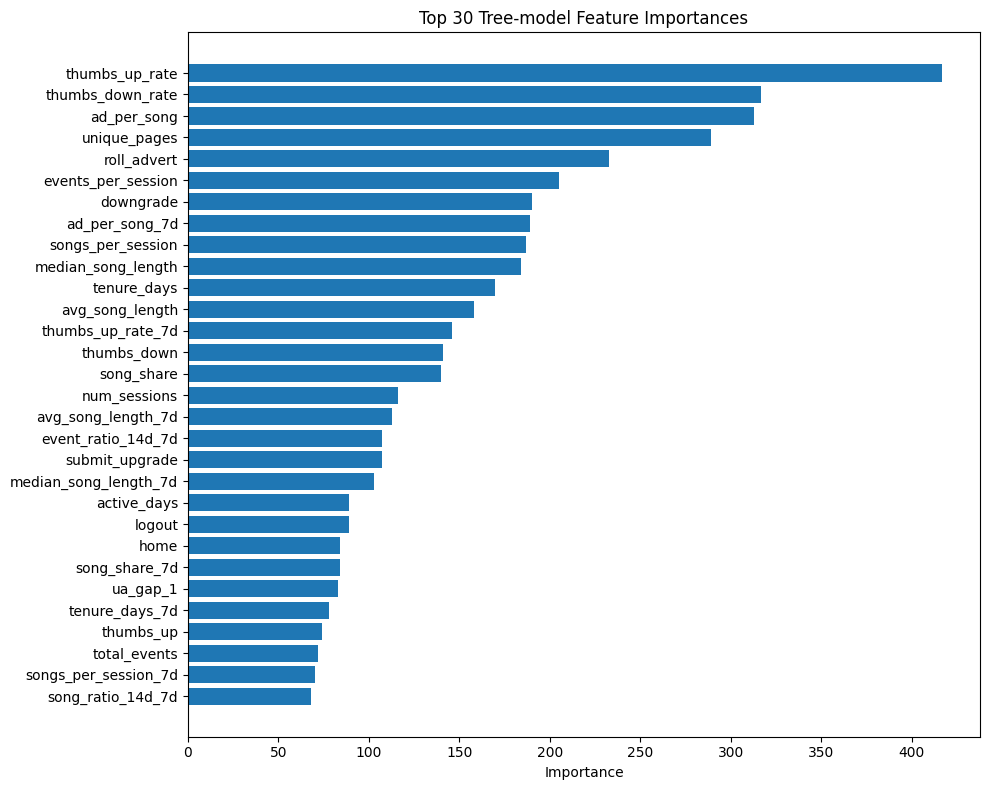

,feature,importance
29,thumbs_up_rate,417
30,thumbs_down_rate,317
28,ad_per_song,313
31,unique_pages,289
2,roll_advert,233
22,events_per_session,205
13,downgrade,190
62,ad_per_song_7d,189
23,songs_per_session,187
26,median_song_length,184


In [ ]:
plot_model_importance(best_model, X_train, top_n=30)


In [ ]:
# 예를 들어 한 window에 대해
obs_mask = (df['time'] >= observation_start) & (df['time'] < observation_end)
pred_mask = (df['time'] >= observation_end) & (df['time'] < prediction_end)

obs_churn_users = df[obs_mask & (df['page']=='Cancellation Confirmation')]['userId'].unique()
pred_churn_users = df[pred_mask & (df['page']=='Cancellation Confirmation')]['userId'].unique()

print("churn in obs:", len(obs_churn_users))
print("churn in pred:", len(pred_churn_users))


churn in obs: 728
churn in pred: 854
